In [66]:
from datetime import datetime, timedelta
import pandas as pd

## 1. Read the raw csv data and explore the data

In [67]:
cols=['id', 'created_at', 'destroyed_at']
server_data = pd.read_csv("servers.csv", delimiter=",", names=cols, header=None )

In [68]:
server_data[0:4]

,id,created_at,destroyed_at
0,2,2015-05-31 14:30:00.000000,2017-08-03 22:42:57.929
1,3,2017-08-03 22:43:07.392988,2017-08-03 22:46:50.279
2,4,2017-08-03 22:46:57.243687,2017-08-08 01:02:16.079
3,5,2017-08-08 01:02:26.761809,2017-08-29 19:57:59.039


In [69]:
cols=['timestamp', 'device_id', 'user_id','server_id', 'connected']
dtypes = {'timestamp': 'str', 'device_id': 'int', 'user_id': 'int', 'server_id': 'int', 'connected':'bool'}
parse_dates = ['timestamp']
events_data = pd.read_csv("connectivity_events.csv", delimiter=",", names=cols, header=None,dtype=dtypes, parse_dates=parse_dates )
#events_data = pd.read_csv("case1.csv", delimiter=",", names=cols, header=None,dtype=dtypes, parse_dates=parse_dates )
#events_data = pd.read_csv("case3.csv", delimiter=",", names=cols, header=None,dtype=dtypes, parse_dates=parse_dates )

In [70]:
#events_data.dtypes
#events_data = events_data.set_index('timestamp')
#events_data[0:5]

In [71]:
events_data.shape

(9308207, 5)

In [72]:
events_data.columns

Index(['timestamp', 'device_id', 'user_id', 'server_id', 'connected'], dtype='object')

## 2. Fill and process the device event stream data 

In [73]:
# start, end takes pandas.Timestamp
def fillDates(start, end):
    #print("fillDates", type(start), start, type(end),end)
    dates = list()
    for i in  range(1,(end.date() - start.date()).days):
        oneday = pd.Timedelta('%d days'%i)
        dates.append(start + oneday)
    return dates

In [74]:
def processEventStream(row):
    r = list()
    dates = list()
    #print(row)

    try:
        if (device_state[row[1]]):
            #print("device details exist")
            #print(row)
            timestamp = row [0]
            device_id = row [1]
            user_id = row [2]
            server_id = row [3]
            next_event = row [4]
            
            if device_state[row[1]]["state"]: # current event 'online'
                if next_event: # next event 'online'
                    if device_state[row[1]]["server"] == server_id: # case 1
                        # Assume device was online from current event's timestamp until next event's timestamp
                        dates = fillDates(device_state[row[1]]["timestamp"], timestamp)
                    else: # case 2 different server
                        # get previous server destruction time
                        destruction_time = pd.Timestamp(server_data[server_data['id'] == 2]['destroyed_at'].values[0])
                        if (pd.Timestamp(destruction_time) < timestamp):
                            dates = fillDates(device_state[row[1]]["timestamp"], destruction_time)
                        else:
                            dates = fillDates(device_state[row[1]]["timestamp"], timestamp)
                    
                    #update the state dictionary Case 1 & 2
                    state_dict = {"state": next_event, "server":server_id, "timestamp":timestamp}
                    device_state[device_id] = state_dict        
                else:# next event 'offline', 
                    if device_state[row[1]]["server"] == server_id: # case 3 Normal case, same next server
                        #update the state dictionary Case 3
                        state_dict = {"state": next_event, "server":server_id, "timestamp":timestamp}
                        device_state[device_id] = state_dict
                    else:# case 4, different next server
                        # get previous server destruction time
                        destruction_time = pd.Timestamp(server_data[server_data['id'] == 2]['destroyed_at'].values[0])
                        dates = fillDates(device_state[row[1]]["timestamp"], destruction_time)
                        # *NO* update for the state dictionary in Case 4
            else:  # current event 'offline'
                if next_event: # next event 'online' # case 5 & case 6: Normal Case
                        #update the state dictionary: case 5 & 6
                        state_dict = {"state": next_event, "server":server_id, "timestamp":timestamp}
                        device_state[device_id] = state_dict
                        dates = list().append(timestamp)
                else: # next event 'offline' # case 7 &  case 8
                        pass # Ignore next event
                
            if dates:
                for d in dates:
                    newentry = list()
                    newentry.append(d)
                    newentry.append(device_id)
                    newentry.append(user_id)
                    #print(newentry)
                    rows_list.append(newentry)
                #print("more dates", dates)
            
    except KeyError:
        state_dict = {"state":row[4], "server":row[3], "timestamp":row[0]}
        device_state[row[1]] = state_dict
        #print(row[1], device_state[row[1]])
        if (row[4]):
            r = row.tolist()
            #print("r",type(r))
            rows_list.append(r[0:3]) 

    return r


In [75]:
device_state = dict()
rows_list = list()
#print( device_state)
#df = small_data.apply(processEventStream, axis=1)
events_data=events_data.apply(processEventStream, axis=1)

In [76]:
events_data_connected =  pd.DataFrame(rows_list)
events_data_connected.columns = ["timestamp", "device_id", "user_id"]

In [77]:
#rows_list

In [78]:
#events_data_connected

In [79]:
events_data_connected.shape

(56587, 3)

In [80]:
events_data_connected.dropna()

,timestamp,device_id,user_id
0,2015-05-31 14:30:00.000,100,4
1,2015-05-31 14:30:00.000,101,1
2,2015-05-31 14:30:00.000,102,1
3,2015-05-31 14:30:00.000,103,26
4,2015-05-31 14:30:00.000,104,1
5,2015-05-31 14:30:00.000,105,1
6,2015-05-31 14:30:00.000,106,1
7,2015-05-31 14:30:00.000,10,6
8,2015-05-31 14:30:00.000,107,1
9,2015-05-31 14:30:00.000,108,27


In [81]:
events_data_connected.shape

(56587, 3)

In [82]:
events_data_connected['date'] = pd.DatetimeIndex(events_data_connected['timestamp']).date

In [83]:
events_data_connected[0:1]

,timestamp,device_id,user_id,date
0,2015-05-31 14:30:00,100,4,2015-05-31


In [84]:
unique_device_per_day = events_data_connected.drop_duplicates(["date", "device_id"],keep = "first")

In [85]:
unique_device_per_day.columns

Index(['timestamp', 'device_id', 'user_id', 'date'], dtype='object')

In [86]:
#dev_count_perday_peruser = unique_device_per_day.groupby(['date', 'user_id']).agg({'device_id':["count"]})

In [87]:
#dev_count_perday_peruser.columns

In [88]:
#dev_count_perday_peruser

In [89]:
dev_count_perday = unique_device_per_day.groupby(['date', 'user_id'])['device_id'].size().reset_index(name='count')

In [90]:
dev_count_perday.columns

Index(['date', 'user_id', 'count'], dtype='object')

In [91]:
type(dev_count_perday)

pandas.core.frame.DataFrame

* 1-2 devices        min
* 3-9 devices        mid
* 10-99 devices      small
* 100-999 devices    large

In [92]:
def func(row):
    if row['count'] < 3:
        val = "min"
    elif row['count'] < 10:
        val = "mid"
    elif row['count'] < 100:
        val = "small" 
    elif row['count'] < 1000:
        val = "large"    
    else:
        val = "xtra-large"
    return val

dev_count_perday['fleet'] = dev_count_perday.apply(func, axis=1)

In [93]:
dev_count_perday[0:3]

,date,user_id,count,fleet
0,2015-05-31,1,131,large
1,2015-05-31,2,1,min
2,2015-05-31,3,1,min


In [94]:
dev_count_perday.dtypes

date       object
user_id     int64
count       int64
fleet      object
dtype: object

In [95]:
fleet_seggregated = dev_count_perday.groupby(['date', 'fleet'])['count'].sum().reset_index(name='device_sum')

In [96]:
bydate_fleet = dev_count_perday.groupby(['date', 'fleet'])['count'].sum().reset_index(name='device_sum')

In [97]:
fleet_seggregated[0:3]

,date,fleet,device_sum
0,2015-05-31,large,131
1,2015-05-31,mid,45
2,2015-05-31,min,56


In [98]:
fleet_seggregated = fleet_seggregated.set_index('date')

In [99]:
fleet_seggregated[0:3]

,fleet,device_sum
date,,
2015-05-31,large,131
2015-05-31,mid,45
2015-05-31,min,56


In [100]:
fleet_seggregated_unstack = fleet_seggregated.groupby(['date', 'fleet']).mean().squeeze().unstack().add_suffix('_count')
#fleet_seggregated_unstack = fleet_seggregated.set_index(['date'])['device_sum'].unstack().add_suffix('_count').reset_index()
#df.set_index(['id','module'])['count'].unstack().add_suffix('_count').reset_index()

In [101]:
fleet_seggregated_unstack[0:3]

fleet,large_count,mid_count,min_count,small_count
date,,,,
2015-05-31,131.0,45.0,56.0,40.0
2015-06-01,NaN,19.0,16.0,NaN
2015-06-02,NaN,10.0,18.0,13.0


## 3. Stack chart depicting the various fleet

default: [6.0, 4.0]


/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


<Figure size 1440x720 with 0 Axes>

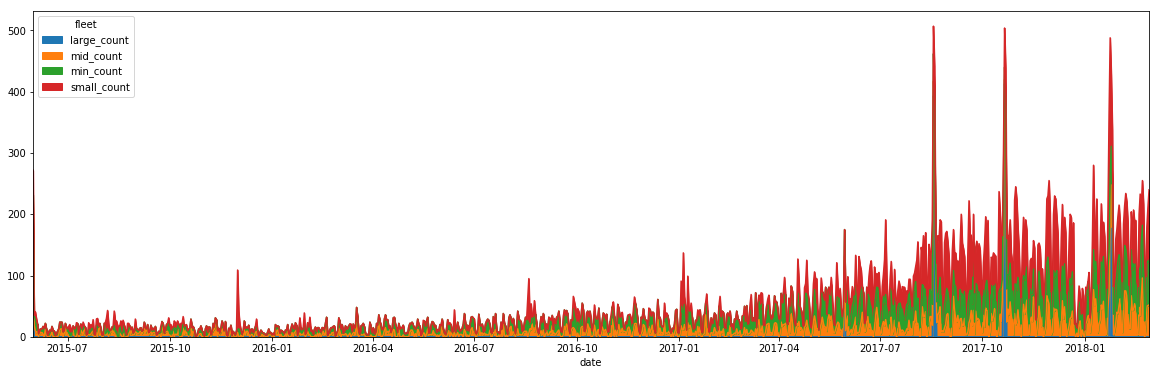

In [102]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


fig_size = plt.rcParams["figure.figsize"]
print("default:", fig_size)
fig_size[0] = 20
fig_size[1] = 6
plt.rcParams["figure.figsize"] =  fig_size 

# plot
plt.figure(figsize=(20,10))
fleet_seggregated_unstack.plot.area().get_figure().savefig('stacked-chart.png')